# Previsão de Rotatividade de Funcionários com Machine Learning

## Descrição do problema

O objetivo deste projeto é desenvolver um modelo de machine learning supervisionado capaz de prever a probabilidade de um funcionário deixar a empresa, utilizando dados históricos do departamento de Recursos Humanos. A partir da análise de variáveis relacionadas ao perfil profissional, desempenho e histórico de trabalho dos colaboradores, o modelo buscará identificar padrões e fatores que influenciam a rotatividade. Com isso, pretende-se oferecer uma ferramenta preditiva que apoie a gestão estratégica de talentos, possibilitando ações preventivas para aumentar a retenção de funcionários, reduzir custos de desligamento e fortalecer a sustentabilidade organizacional.

### Resumo dos insumos
Os dados coletados pelo departamento de RH de uma empresa a serem trabalhados neste projeto.

| Variável | Descrição |
| -------- | --------- |
| Age | Idade do funcionário |
| Attrition | Funcionário que saiu da empresa (0=não, 1=sim) |
| BusinessTravel | Indica a frequência com que o funcionário viaja |
| Department | Indica o departamento em que o funcionário trabalha |
| DistanceFromHome | Distância da casa do funcionário até a empresa |
| Education | Nível de escolaridade (1='Abaixo da faculdade', 2='Universidade', 3='Bacharelado', 4='Mestrado', 5='Doutor') |
| EducationField | Área de estudo dos funcionários |
| EmployeeCount | Contagem de funcionários |
| EmployeeID | Número de identificação do funcionário |
| Gender | Sexo do funcionário |
| JobLevel | Nível da função do funcionário na empresa |
| JobRole | Nome da função do funcionário |
| MaritalStatus | Estado civil do funcionário |
| MonthlyIncome | Renda mensal do funcionário |
| NumCompaniesWorked | Número de empresas em que o funcionário já trabalhou |
| Over18 | se o funcionário tem mais de 18 anos (verdadeiro/falso) |
| PercentSalaryHike | Aumento percentual do salário |
| StandardHours | Horário de trabalho padrão |
| StockOptionLevel | Participação em ações (Quanto maior for o número, mais opções de ações um funcionário tem) |
| TotalWorkingYears | Anos trabalhados |
| TrainingTimesLastYear | Total de horas dedicadas ao treinamento no último ano |
| YearsAtCompany | Anos trabalhados nesta empresa |
| YearsSinceLastPromotion | Anos desde a última promoção |
| YearsWithCurrManag | Anos trabalhando com o gerente atual |

## Imports e dataset

In [208]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

In [209]:
roboto_path = "../fonts/Roboto-Regular.ttf"
fm.fontManager.addfont(roboto_path)
plt.rcParams['font.family'] = 'roboto'

In [210]:
df = pd.read_csv("../data/rh_data.csv")

## 1. Tratamento dos dados

In [211]:
df.shape

(4410, 24)

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### a. Identificação e tratamento dos nulos

In [213]:
df[['NumCompaniesWorked', 'TotalWorkingYears']].isna().sum()

NumCompaniesWorked    19
TotalWorkingYears      9
dtype: int64

In [214]:
df[df[['NumCompaniesWorked', 'TotalWorkingYears']].isna().all(axis=1)]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager


In [215]:
df['NumCompaniesWorked'] = df['NumCompaniesWorked'].fillna(1)

In [216]:
df.loc[
    df['TotalWorkingYears'].isna() & (df['NumCompaniesWorked'] == 1),
    'TotalWorkingYears'
] = df['YearsAtCompany']

In [217]:
df = df.dropna()

In [218]:
df[['NumCompaniesWorked', 'TotalWorkingYears']].isna().sum()

NumCompaniesWorked    0
TotalWorkingYears     0
dtype: int64

### b. Identificação e tratamento das duplicatas

In [219]:
df.duplicated().any()

np.False_

In [220]:
df[df['EmployeeID'].duplicated()]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager


### c. Gerenciamento dos dados

🔵 Identificar e gerenciar dados fora do escopo de análise

🔵 Identificar e tratar dados discrepantes em variáveis ​​categóricas

🔵 Identificar e tratar dados discrepantes em variáveis ​​numéricas

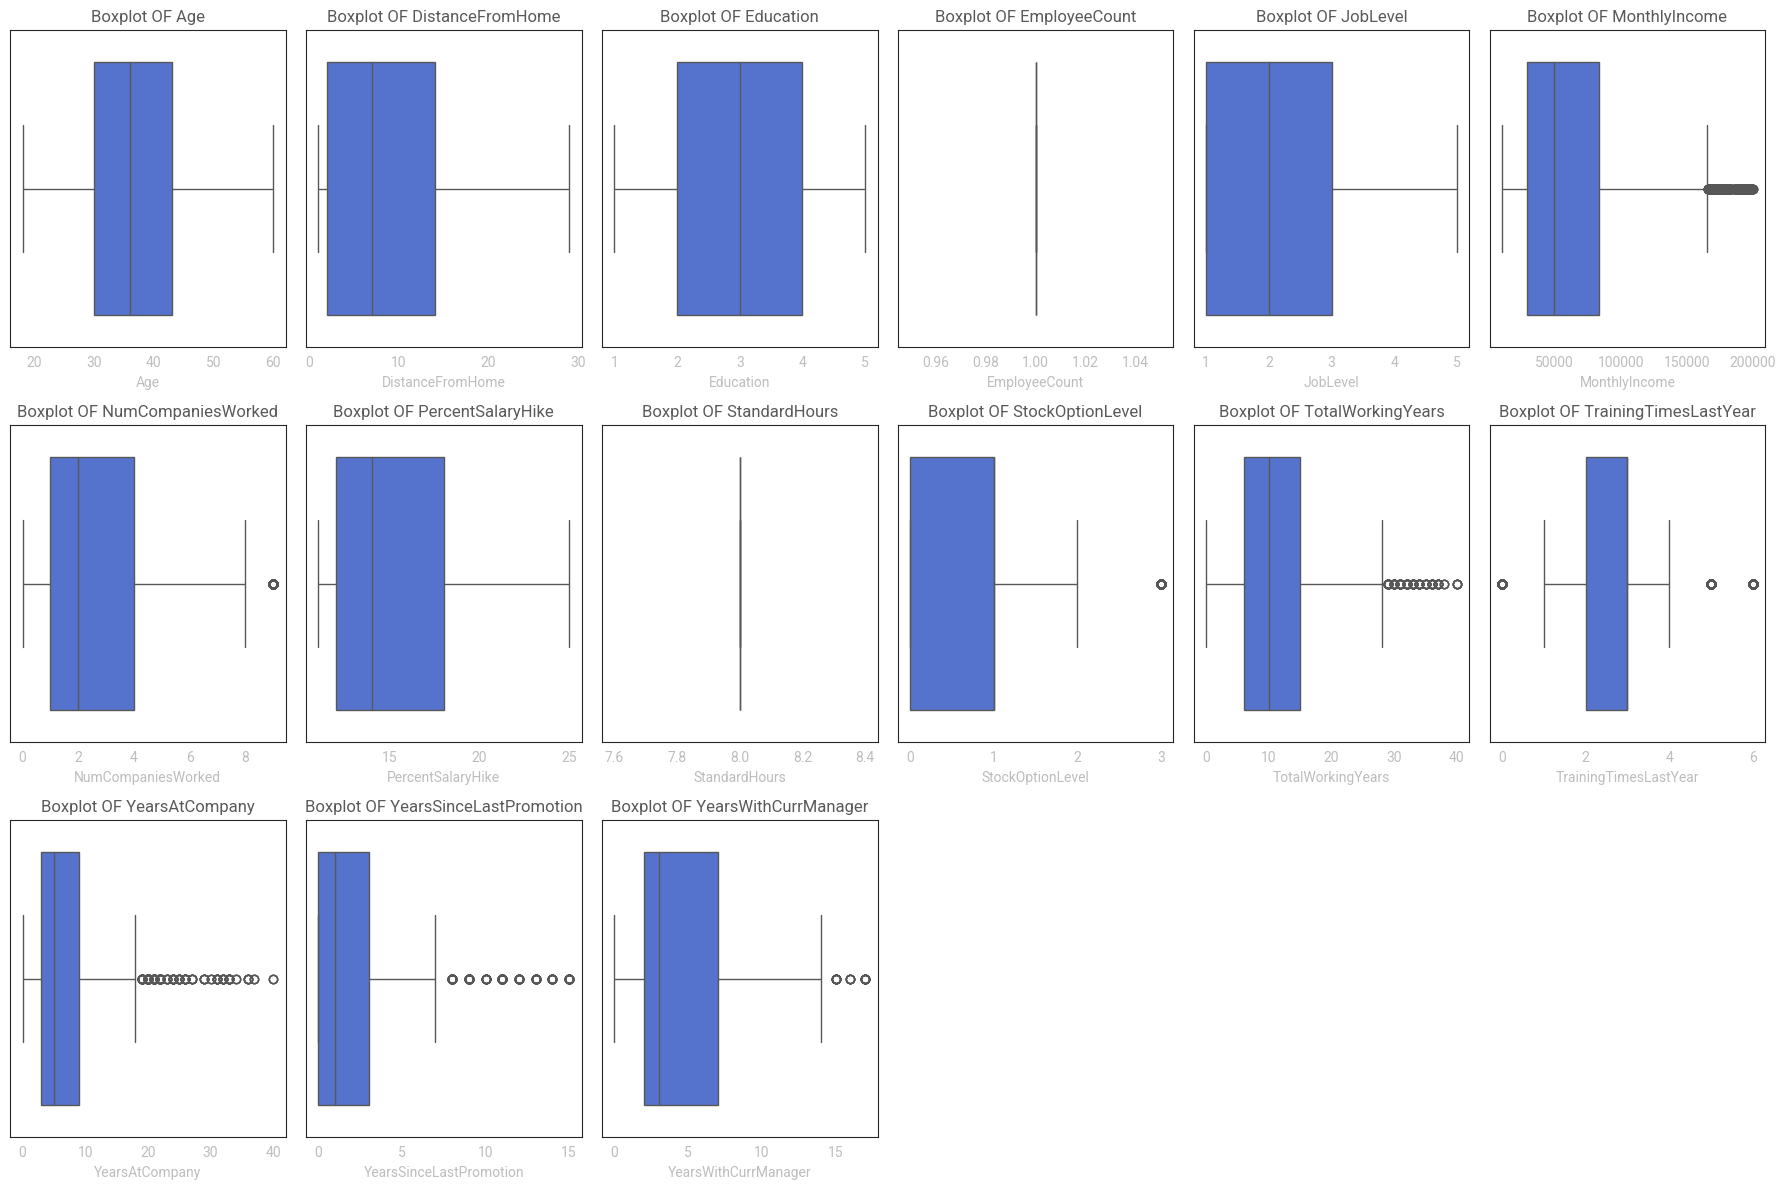

In [221]:
analysis_columns = df.select_dtypes(include=['int64', 'float64']).columns.difference(['EmployeeID'])

n_cols = 6
n_rows = math.ceil(len(analysis_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot OF {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

EmployeeCount, Over18, StandardHours parecem constantes em todo o dataset, então foram removidas

In [222]:
df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], inplace=True)

In [223]:
df['NumCompaniesWorked'].value_counts()

NumCompaniesWorked
1.0    1577
0.0     584
3.0     474
2.0     438
4.0     413
7.0     219
6.0     208
5.0     187
9.0     156
8.0     147
Name: count, dtype: int64

In [224]:
df.loc[df['NumCompaniesWorked'] == 0, 'NumCompaniesWorked'] = 1

In [225]:
for col in df.select_dtypes('object'):
    print(col, df[col].unique())

Attrition ['No' 'Yes']
BusinessTravel ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department ['Sales' 'Research & Development' 'Human Resources']
EducationField ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender ['Female' 'Male']
JobRole ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus ['Married' 'Single' 'Divorced']


In [226]:
categorical_cols = df.select_dtypes('object').columns
df[categorical_cols] = df[categorical_cols].astype('category')

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4403 entries, 0 to 4408
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      4403 non-null   int64   
 1   Attrition                4403 non-null   category
 2   BusinessTravel           4403 non-null   category
 3   Department               4403 non-null   category
 4   DistanceFromHome         4403 non-null   int64   
 5   Education                4403 non-null   int64   
 6   EducationField           4403 non-null   category
 7   EmployeeID               4403 non-null   int64   
 8   Gender                   4403 non-null   category
 9   JobLevel                 4403 non-null   int64   
 10  JobRole                  4403 non-null   category
 11  MaritalStatus            4403 non-null   category
 12  MonthlyIncome            4403 non-null   int64   
 13  NumCompaniesWorked       4403 non-null   float64 
 14  PercentSalary

### d. Criação de variáveis

In [228]:
bins = [18, 25, 35, 45, 55, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [229]:
df['AvgYearsPerCompany'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']

In [230]:
df['PromotionRate'] = df['YearsSinceLastPromotion'] / (df['TotalWorkingYears'] + 1)

In [231]:
df['FarFromHome'] = (df['DistanceFromHome'] > df['DistanceFromHome'].median()).astype(int)

In [232]:
df['SalaryHikePerIncome'] = df['PercentSalaryHike'] / df['MonthlyIncome']

In [233]:
df['EducationDomain'] = df['EducationField'].map({
    'Life Sciences': 'STEM',
    'Medical': 'STEM',
    'Technical Degree': 'STEM',
    'Human Resources': 'Business',
    'Marketing': 'Business',
    'Other': 'Other'
}).astype('category')

In [234]:
df['CompanyExperienceRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)

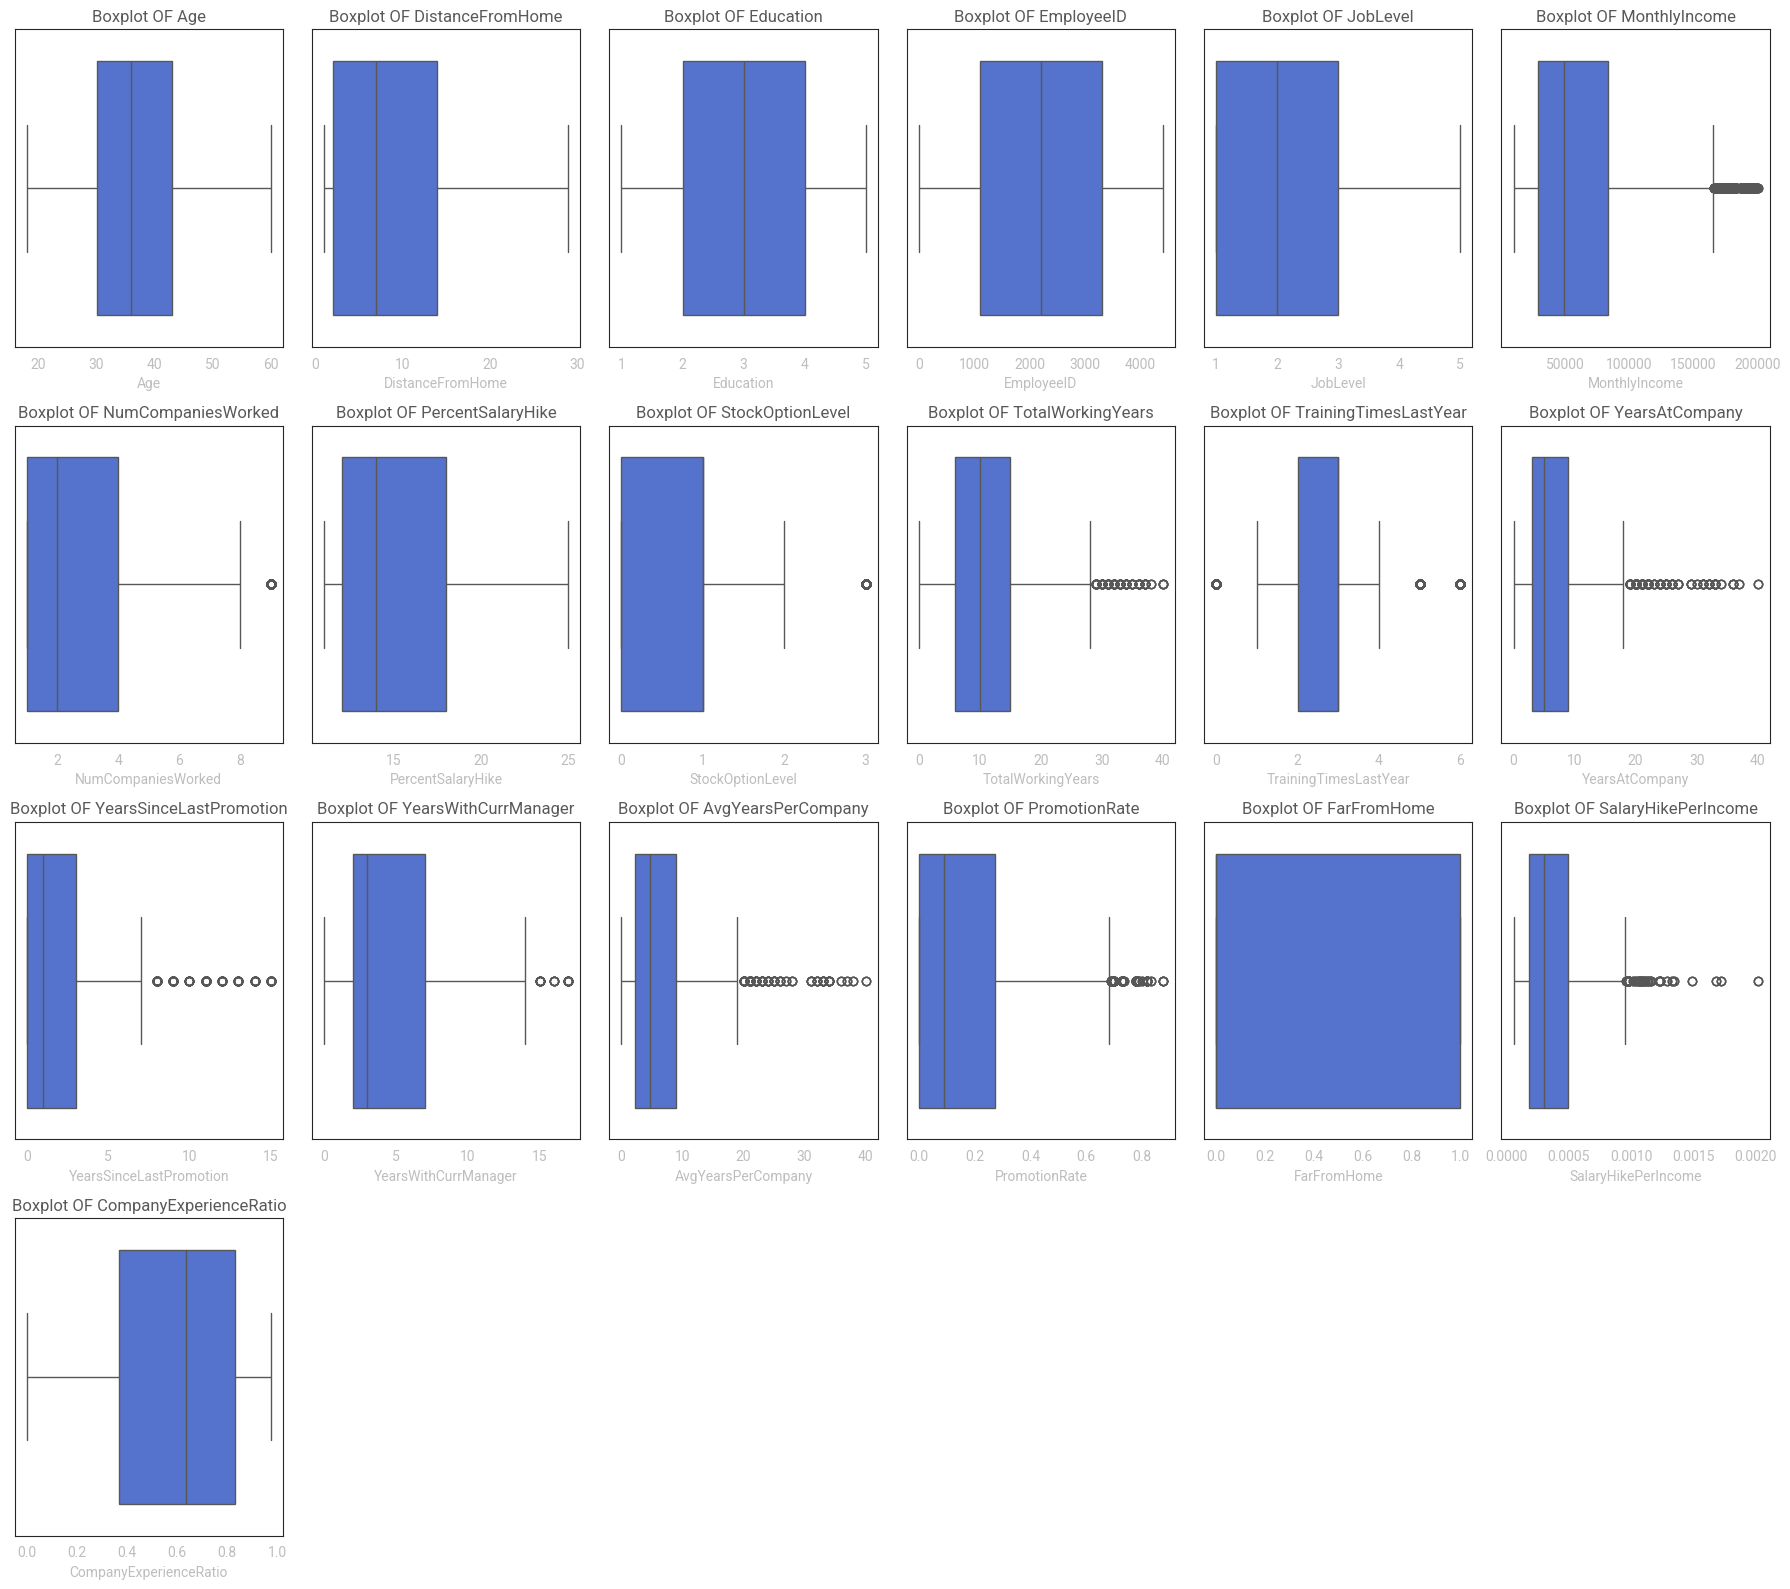

In [235]:
analysis_columns = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 6
n_rows = math.ceil(len(analysis_columns) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()
for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot OF {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2. Análise Exploratória dos Dados (AED/EDA)

In [236]:
categorical_cols = df.select_dtypes('category').columns.tolist()
analysis_columns = df.select_dtypes(include=['int64', 'float64']).columns.difference(['EmployeeID'])

### a. Ver variáveis categóricas

In [237]:
for col in categorical_cols:
    print(f"\n{col}:")
    display(
        pd.crosstab(df[col], df['Attrition'], normalize='index').round(3)
    )


Attrition:


Attrition,No,Yes
Attrition,,
No,1.0,0.0
Yes,0.0,1.0



BusinessTravel:


Attrition,No,Yes
BusinessTravel,,
Non-Travel,0.920,0.080
Travel_Frequently,0.752,0.248
Travel_Rarely,0.850,0.150



Department:


Attrition,No,Yes
Department,,
Human Resources,0.698,0.302
Research & Development,0.843,0.157
Sales,0.850,0.150



EducationField:


Attrition,No,Yes
EducationField,,
Human Resources,0.593,0.407
Life Sciences,0.833,0.167
Marketing,0.843,0.157
Medical,0.838,0.162
Other,0.878,0.122
Technical Degree,0.886,0.114



Gender:


Attrition,No,Yes
Gender,,
Female,0.847,0.153
Male,0.833,0.167



JobRole:


Attrition,No,Yes
JobRole,,
Healthcare Representative,0.855,0.145
Human Resources,0.865,0.135
Laboratory Technician,0.837,0.163
Manager,0.863,0.137
Manufacturing Director,0.889,0.111
Research Director,0.766,0.234
Research Scientist,0.818,0.182
Sales Executive,0.831,0.169
Sales Representative,0.855,0.145



MaritalStatus:


Attrition,No,Yes
MaritalStatus,,
Divorced,0.899,0.101
Married,0.875,0.125
Single,0.745,0.255



AgeGroup:


Attrition,No,Yes
AgeGroup,,
18-25,0.608,0.392
26-35,0.798,0.202
36-45,0.899,0.101
46-55,0.899,0.101
56+,0.841,0.159



EducationDomain:


Attrition,No,Yes
EducationDomain,,
Business,0.806,0.194
Other,0.878,0.122
STEM,0.841,0.159


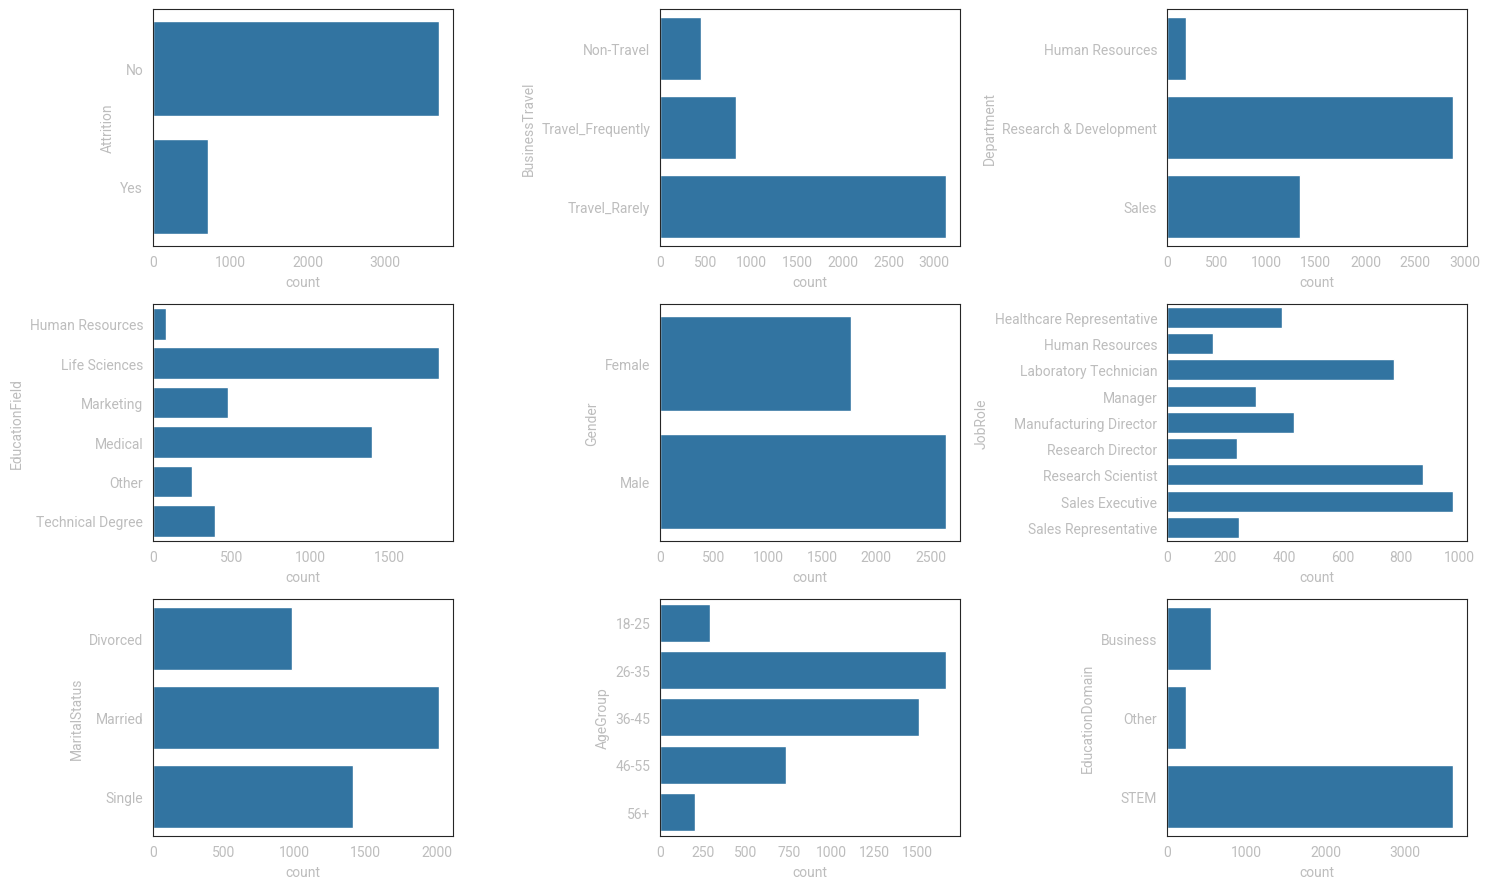

In [238]:
N_COLS = 3
N_ROWS = math.ceil(len(categorical_cols) / N_COLS)

plt.figure(figsize=(5 * N_COLS, 3 * N_ROWS))
plt.subplots_adjust(hspace=0.3)

for i, col in enumerate(categorical_cols):
    plt.subplot(N_ROWS, N_COLS, i + 1)
    sns.countplot(data=df, y=col)  

plt.tight_layout()
plt.show()

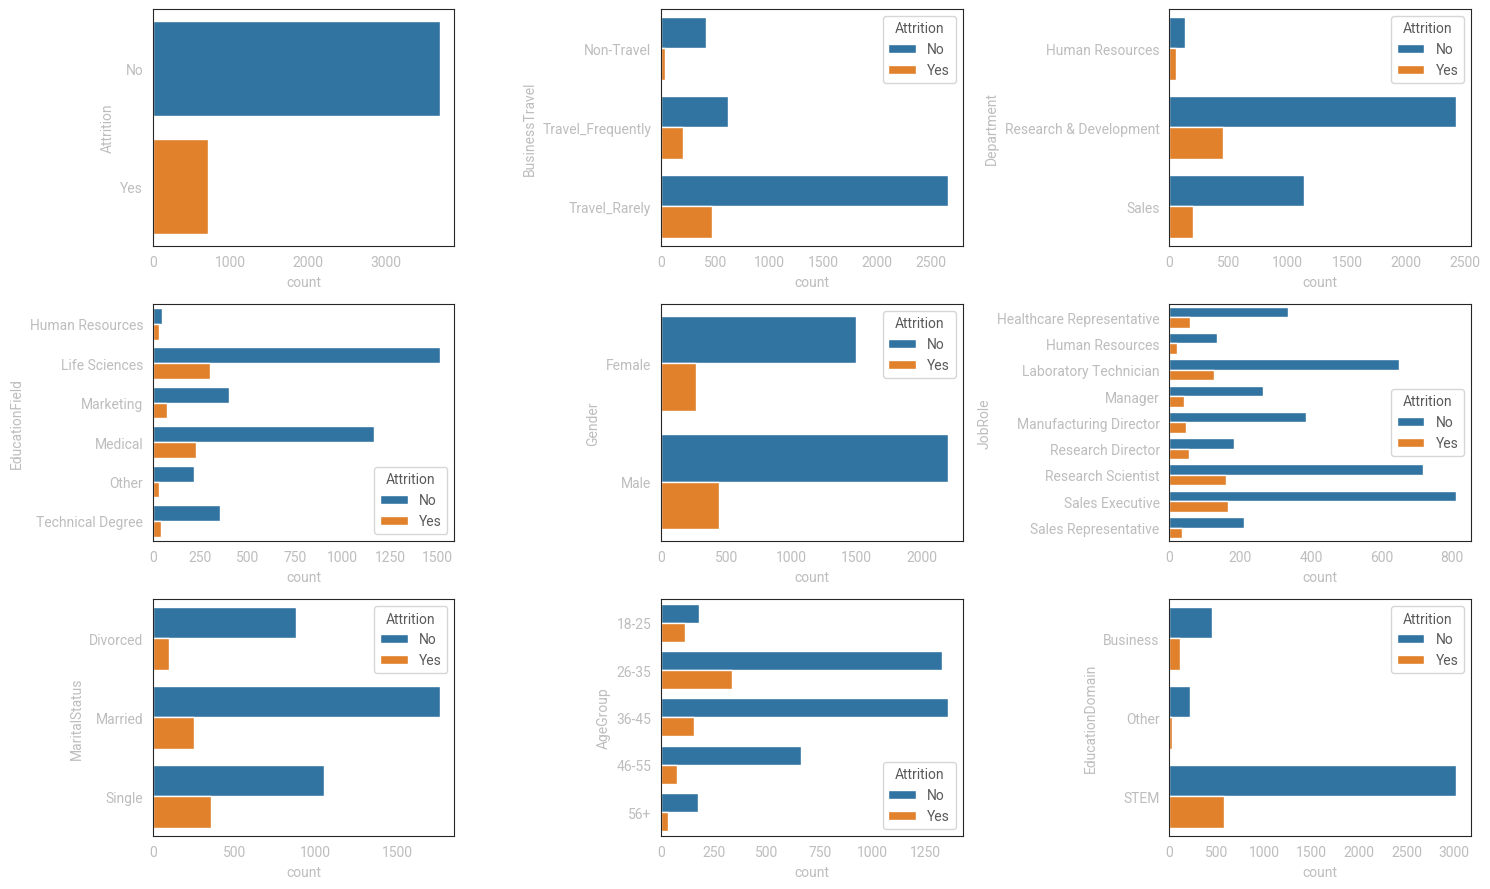

In [239]:
N_COLS = 3
N_ROWS = math.ceil(len(categorical_cols) / N_COLS)

plt.figure(figsize=(5 * N_COLS, 3 * N_ROWS))
plt.subplots_adjust(hspace=0.3)

for i, col in enumerate(categorical_cols):
    plt.subplot(N_ROWS, N_COLS, i + 1)
    sns.countplot(data=df, y=col, hue='Attrition')

plt.tight_layout()
plt.show()

### b. Ver distribuição

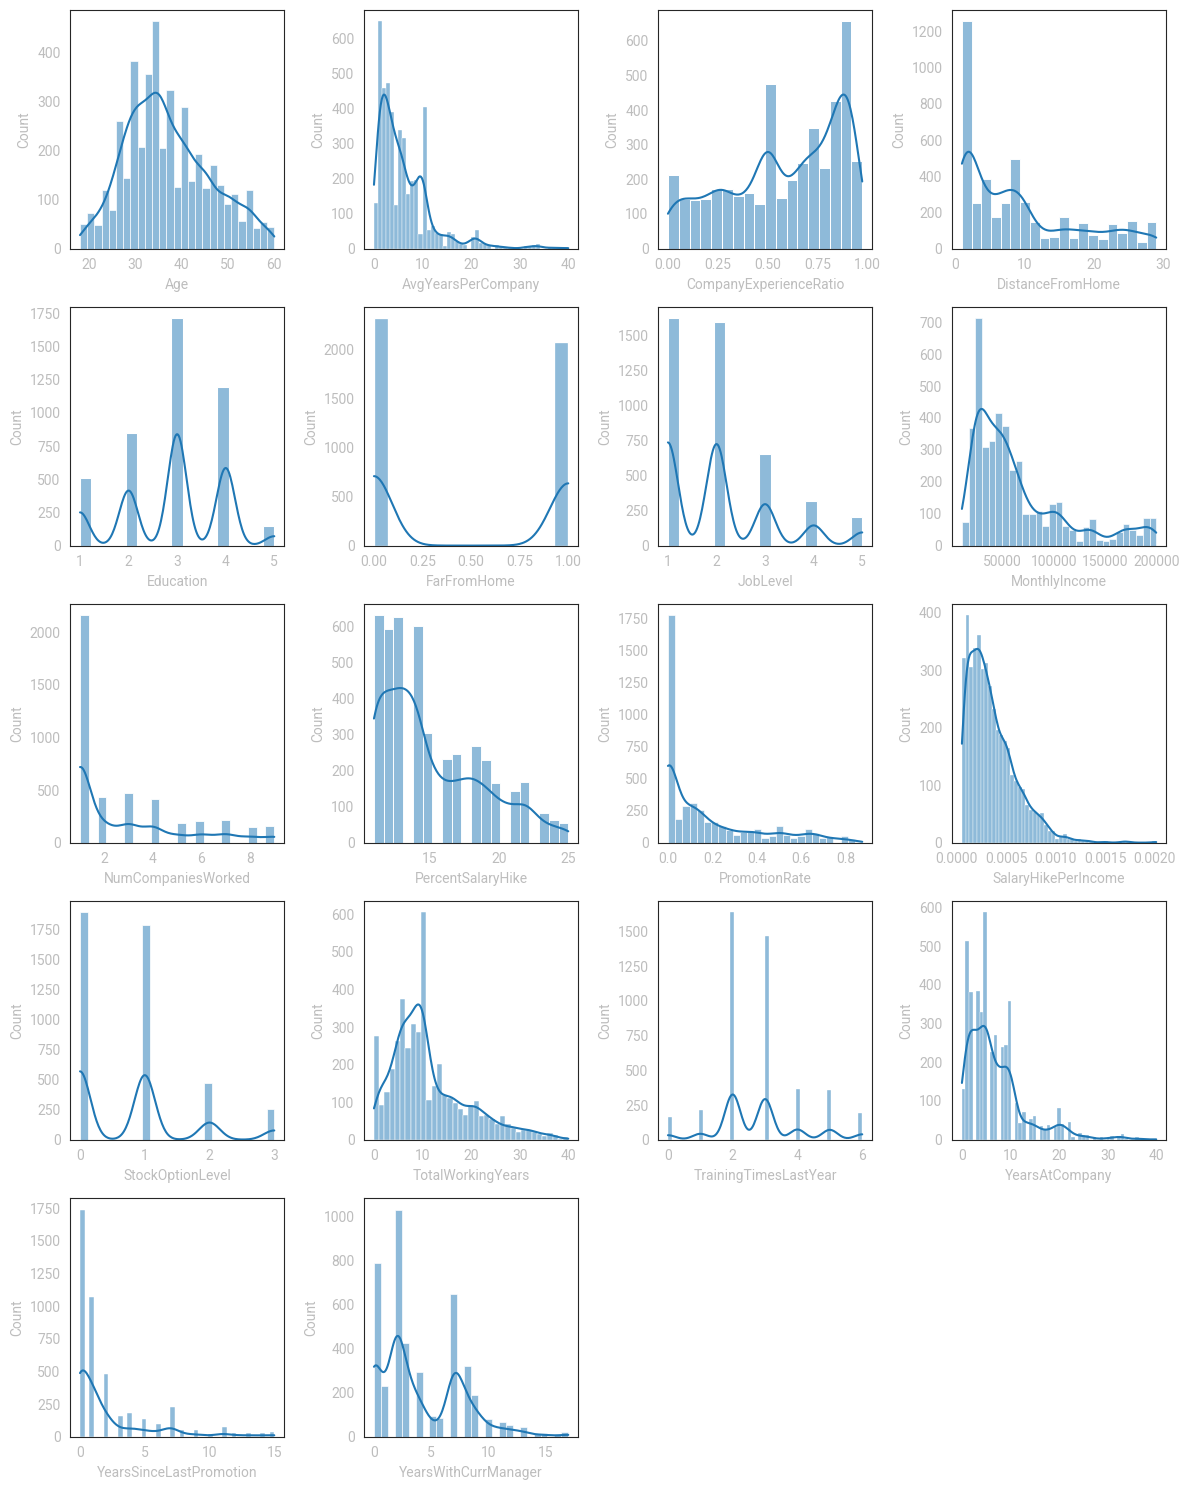

In [240]:
N_COLS = 4
N_ROWS = math.ceil(len(analysis_columns) / N_COLS)

plt.figure(figsize=(3 * N_COLS, 3 * N_ROWS))
plt.subplots_adjust(hspace=0.2)

for i, col in enumerate(analysis_columns):
    plt.subplot(N_ROWS, N_COLS, i + 1)
    sns.histplot(data=df, x=col, kde=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

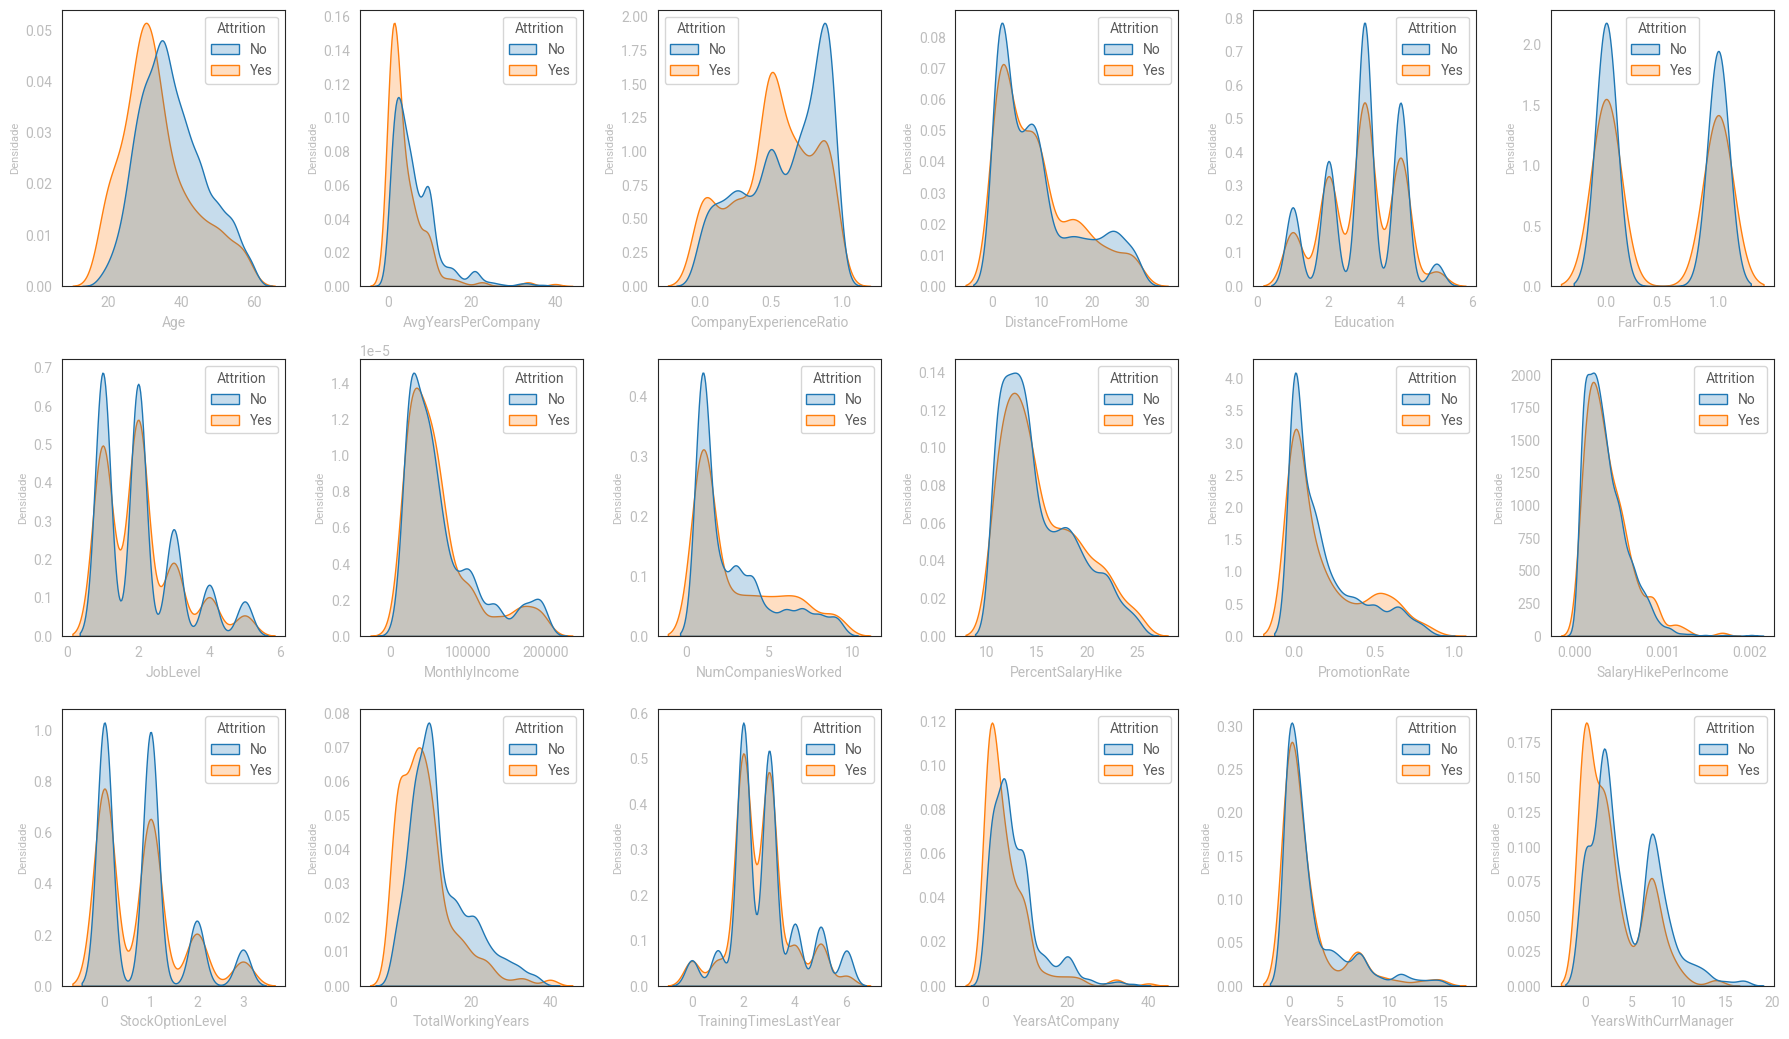

In [241]:
N_COLS = 6
analysis_cols_list = [col for col in analysis_columns if col != 'Attrition']
N_ROWS = math.ceil(len(analysis_cols_list) / N_COLS)

plt.figure(figsize=(3 * N_COLS, 3.5 * N_ROWS))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(analysis_cols_list):
    if df[col].var() == 0:
        print(f"ATENÇÃO: Coluna '{col}' possui variância zero e foi pulada.")
        continue
    
    plt.subplot(N_ROWS, N_COLS, i + 1)

    sns.kdeplot(
        data=df, 
        x=col, 
        hue='Attrition', 
        fill=True, 
        common_norm=False, 
        warn_singular=False 
    )

    plt.xlabel(col, fontsize=10)
    plt.ylabel('Densidade', fontsize=8)

plt.tight_layout()
plt.show()

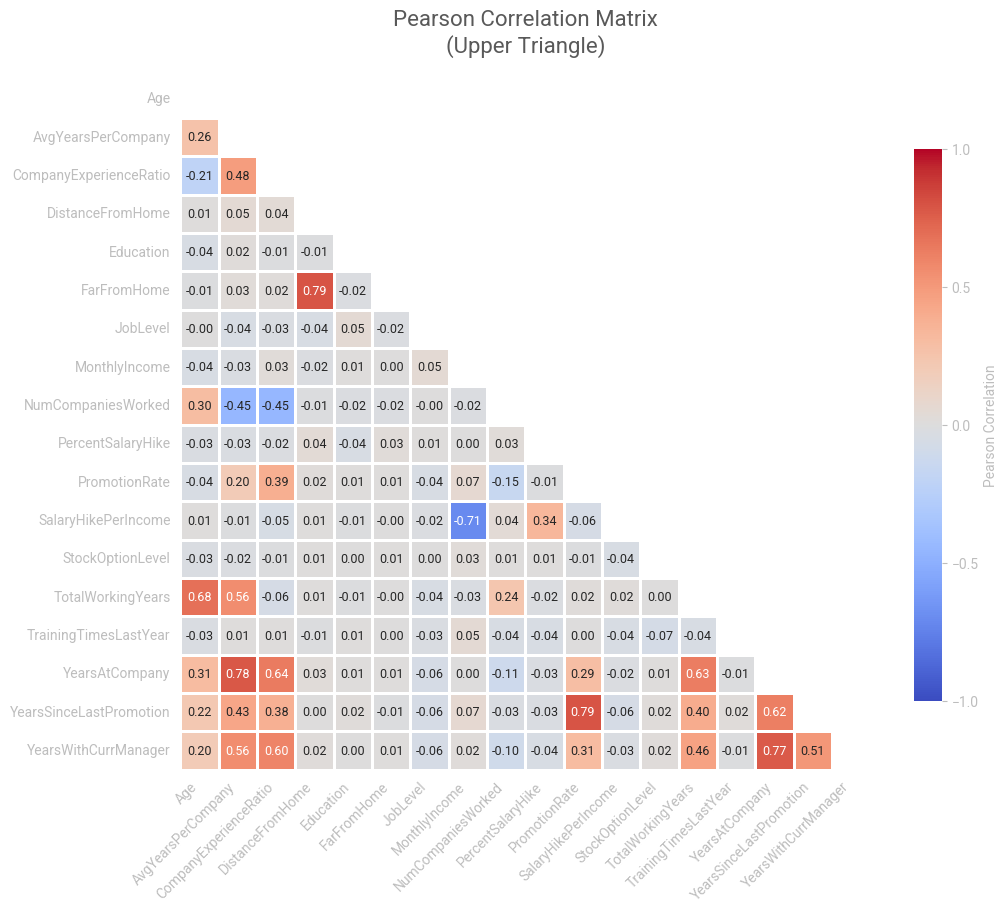

In [242]:
correlation_matrix = df[analysis_columns].corr(method='pearson')

plt.figure(figsize=(len(analysis_columns) * 0.6, len(analysis_columns) * 0.5))

mask_low_corr = (np.abs(correlation_matrix) < 0.1) & (correlation_matrix != 1.0)

sns.heatmap(
    correlation_matrix.round(2),
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.8,
    square=True,
    center=0,
    vmin=-1, vmax=1,
    cbar_kws={
        "shrink": 0.8,
        "label": "Pearson Correlation",
        "ticks": [-1, -0.5, 0, 0.5, 1]
    },
    annot_kws={
        "fontsize": 9
    }
)

plt.title("Pearson Correlation Matrix\n(Upper Triangle)", 
          fontsize=16, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

### c. Ver métricas estatísticas

In [243]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4403.0,36.919600,9.138611,18.000000,30.000000,36.000000,43.000000,60.000000
DistanceFromHome,4403.0,9.187145,8.102055,1.000000,2.000000,7.000000,14.000000,29.000000
Education,4403.0,2.912560,1.024389,1.000000,2.000000,3.000000,4.000000,5.000000
EmployeeID,4403.0,2206.181240,1272.721483,1.000000,1104.500000,2206.000000,3308.500000,4409.000000
JobLevel,4403.0,2.064729,1.107013,1.000000,1.000000,2.000000,3.000000,5.000000
MonthlyIncome,4403.0,65025.271406,47071.504652,10090.000000,29110.000000,49080.000000,83800.000000,199990.000000
NumCompaniesWorked,4403.0,2.817851,2.371836,1.000000,1.000000,2.000000,4.000000,9.000000
PercentSalaryHike,4403.0,15.207359,3.658456,11.000000,12.000000,14.000000,18.000000,25.000000
StockOptionLevel,4403.0,0.794004,0.852098,0.000000,0.000000,1.000000,1.000000,3.000000
TotalWorkingYears,4403.0,11.279582,7.783106,0.000000,6.000000,10.000000,15.000000,40.000000


In [244]:
df.groupby('Attrition', observed=False)[num_cols].mean().T

Attrition,No,Yes
Age,37.559978,33.588732
DistanceFromHome,9.219334,9.019718
Education,2.919307,2.877465
EmployeeID,2208.442459,2194.419718
JobLevel,2.069591,2.039437
MonthlyIncome,65658.724614,61730.422535
NumCompaniesWorked,2.778771,3.021127
PercentSalaryHike,15.154075,15.484507
StockOptionLevel,0.796642,0.780282
TotalWorkingYears,11.862984,8.245070


### d. Removendo variáveis não correlacionadas e que não agregarão ao modelo

Essas variáveis não mostraram diferenças relevantes entre os grupos, sugerindo que, isoladamente, não são bons preditores de Attrition: Education, FarFromHome, JobLevel, NumCompaniesWorked, PromotionRate, StockOptionLevel, TrainingTimesLastYear

Variáveis como MonthlyIncome, PercentSalaryHike e StockOptionLevel não mostraram correlações fortes com outras métricas, o que indica que o nível de remuneração pode depender de múltiplos fatores não diretamente capturados por idade ou tempo de empresa.

In [245]:
df_model = df.copy()
df_model = df_model.drop(columns=['Education', 'FarFromHome', 'JobLevel', 'NumCompaniesWorked', 'PromotionRate', 'StockOptionLevel', 'TrainingTimesLastYear', 'MonthlyIncome', 'PercentSalaryHike'])

## 3. Modelagem Supervisionada

### a. Preparação dos dados

Codificar variáveis categóricas, normalizar variáveis numéricas e dividir a base em treino e teste

In [246]:
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns

encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    encoders[col] = le

In [247]:
X = df_model.drop(columns=['Attrition'])
y = df_model['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### b. Regressão Logística

In [248]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
print(f"Acurácia - Logistic Regression: {acc_log:.4f}")

Acurácia - Logistic Regression: 0.8479


### c. Random Forest

In [249]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia - Random Forest: {acc_rf:.4f}")

Acurácia - Random Forest: 0.9852


### d. XGBoost

In [250]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Acurácia - XGBoost: {acc_xgb:.4f}")

Acurácia - XGBoost: 0.9966


### e. Resultados

In [251]:
def evaluate_model(model_name, y_true, y_pred, y_proba=None):
    metrics = {
        "Modelo": model_name,
        "Acurácia": accuracy_score(y_true, y_pred),
        "Precisão": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_proba is not None:
        metrics["AUC-ROC"] = roc_auc_score(y_true, y_proba)
    else:
        metrics["AUC-ROC"] = None
    return metrics

In [252]:
results = [
    evaluate_model("Logistic Regression", y_test, y_pred_log, y_proba_log),
    evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf),
    evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb),
]

metrics_df = pd.DataFrame(results)
display(metrics_df)

,Modelo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.847900,0.653846,0.119718,0.202381,0.710439
1,Random Forest,0.985244,0.992366,0.915493,0.952381,0.999347
2,XGBoost,0.996595,1.000000,0.978873,0.989324,0.990556


In [253]:
coef = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': logreg.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)
coef

,Variável,Coeficiente
10,YearsAtCompany,0.868435
8,MaritalStatus,0.596774
11,YearsSinceLastPromotion,0.339489
6,Gender,0.098292
15,SalaryHikePerIncome,0.063354
5,EmployeeID,0.021712
7,JobRole,0.013466
1,BusinessTravel,0.013073
3,DistanceFromHome,0.009364
4,EducationField,-0.074262


## 4. Criação de imagens para resultados

In [254]:
df.shape

(4403, 28)

In [255]:
df_model.shape

(4403, 19)

In [256]:
palette_attrition = ['#1b9ba8', '#c75146']

In [257]:
def plot_categorical_distribution(
    df, 
    col, 
    hue=None, 
    palette=palette_attrition, 
    title_prefix='Distribuição de'
):
    """
    Cria um gráfico de barras horizontal minimalista para uma variável categórica.
    """
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8, 5))

    if hue and hue in df.columns:
        sns.countplot(
            data=df, 
            y=col, 
            hue=hue, 
            palette=palette, 
            ax=ax,
            legend=False
        )

    else:
        sns.countplot(
            data=df, 
            y=col, 
            palette=palette, 
            ax=ax,
            legend=False
        )

    sns.despine(left=True, bottom=True)
    ax.set_xlabel("")  
    ax.set_ylabel("")  
    ax.set_title(f"{title_prefix} {col}", fontsize=14, fontweight="bold")
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


In [258]:
def plot_categorical_distribution_with_porcentage(
    df, 
    col, 
    hue=None, 
    palette=palette_attrition, 
    title_prefix='Distribuição de'
):
    """
    Cria um gráfico de barras horizontal minimalista para uma variável categórica.
    Mostra porcentagem nas barras e remove bordas externas e legendas.
    """
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8, 5))

    if hue and hue in df.columns:
        sns.countplot(
            data=df, 
            y=col, 
            hue=hue, 
            palette=palette, 
            ax=ax,
            legend=False
        )
        for container in ax.containers:
            total_per_cat = (
                df[col].value_counts().reindex([t.get_text() for t in ax.get_yticklabels()])
            )
            for bar, total in zip(container, total_per_cat):
                width = bar.get_width()
                pct = (width / total) * 100 if total and total > 0 else 0
                ax.text(
                    width + 1, 
                    bar.get_y() + bar.get_height() / 2,
                    f"{pct:.1f}%", 
                    ha="left", va="center", fontsize=10
                )
    else:
        sns.countplot(
            data=df, 
            y=col, 
            palette=palette, 
            ax=ax,
            legend=False
        )
        total = len(df)
        for container in ax.containers:
            for bar in container:
                width = bar.get_width()
                pct = (width / total) * 100
                ax.text(
                    width + 1, 
                    bar.get_y() + bar.get_height() / 2,
                    f"{pct:.1f}%", 
                    ha="left", va="center", fontsize=10
                )
    sns.despine(left=True, bottom=True)
    ax.set_xlabel("")  
    ax.set_ylabel("")  
    ax.set_title(f"{title_prefix} {col}", fontsize=14, fontweight="bold")
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


C:\Users\Vitoria\AppData\Local\Temp\ipykernel_26904\309392025.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


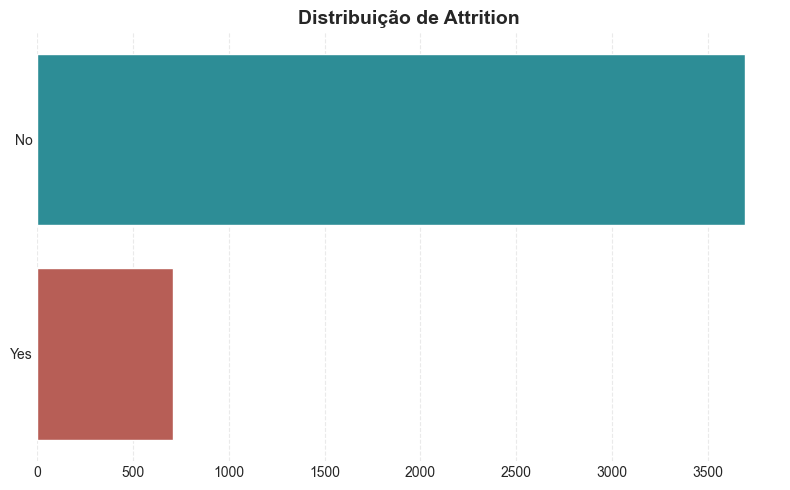

In [259]:
plot_categorical_distribution(df, 'Attrition', hue=None)

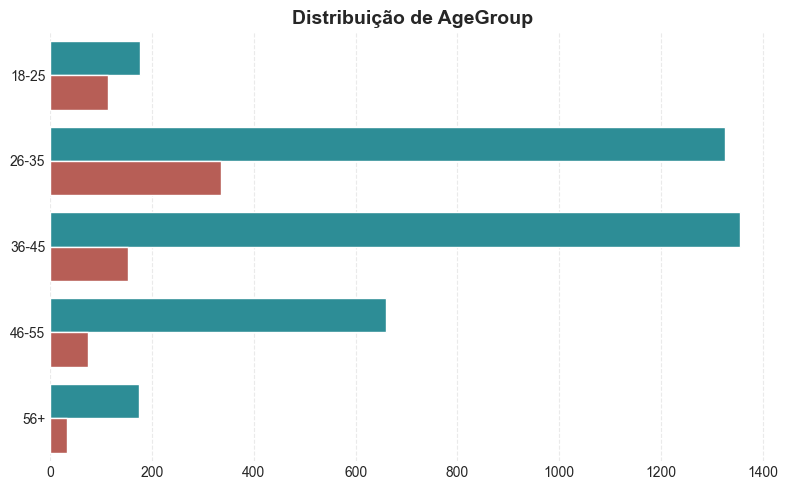

In [260]:
plot_categorical_distribution(df, 'AgeGroup', hue='Attrition')

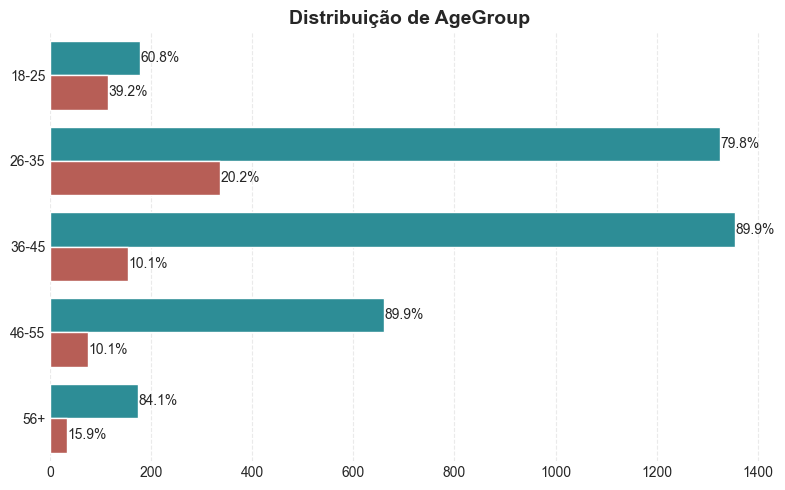

In [261]:
plot_categorical_distribution_with_porcentage(df, 'AgeGroup', hue='Attrition')

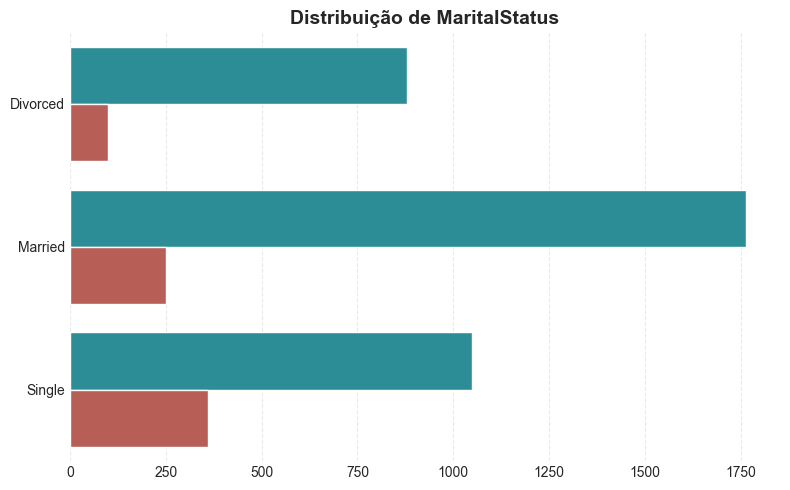

In [262]:
plot_categorical_distribution(df, 'MaritalStatus', hue='Attrition')

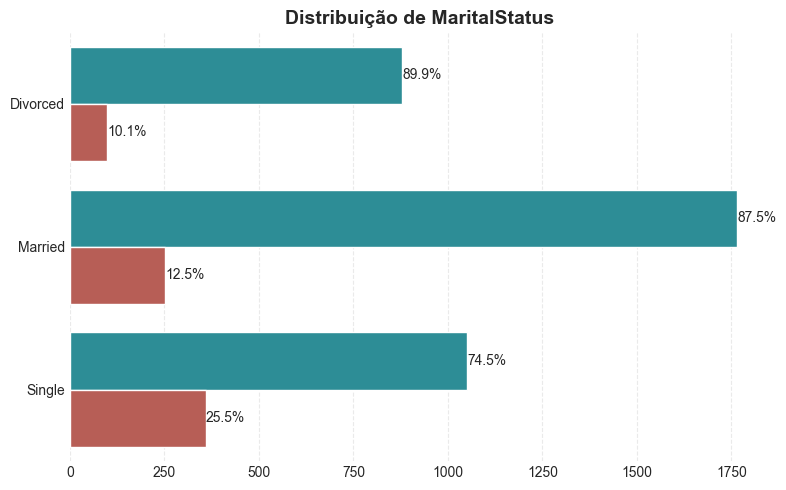

In [263]:
plot_categorical_distribution_with_porcentage(df, 'MaritalStatus', hue='Attrition')

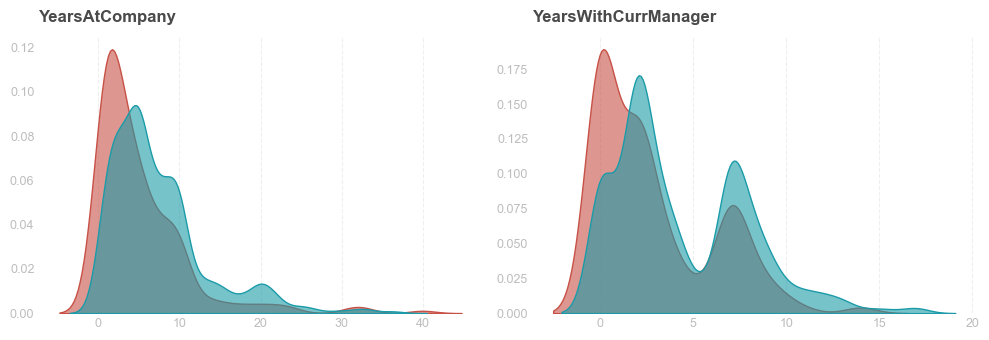

In [264]:
plt.rcParams['text.color'] = '#595959'
plt.rcParams['axes.labelcolor'] = '#bdbdbd'
plt.rcParams['xtick.color'] = '#bdbdbd'
plt.rcParams['ytick.color'] = '#bdbdbd'

N_COLS = 2
analysis_cols_list = ['YearsAtCompany', 'YearsWithCurrManager']
N_ROWS = math.ceil(len(analysis_cols_list) / N_COLS)

plt.figure(figsize=(5 * N_COLS, 3.5 * N_ROWS))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(analysis_cols_list):
    if df[col].var() == 0:
        print(f"ATENÇÃO: Coluna '{col}' possui variância zero e foi pulada.")
        continue

    plt.subplot(N_ROWS, N_COLS, i + 1)

    sns.kdeplot(
        data=df,
        x=col,
        hue='Attrition',
        fill=True,
        common_norm=False,
        warn_singular=False,
        palette=palette_attrition,
        alpha=0.6
    )

    plt.title(col, fontsize=12, fontweight="bold", loc='left', pad=10, color='#4A4A4A')
    plt.xlabel("")  
    plt.ylabel("")  

    sns.despine(left=True, bottom=True)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tick_params(axis='both', which='both', length=0, labelsize=9)

    plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [265]:
def plot_model_comparison(metrics_df):
    """
    Plota gráfico de barras comparando métricas entre modelos.
    """
    melted = metrics_df.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")
    melted = melted.dropna(subset=["Valor"])
    
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=melted,
        x="Métrica", y="Valor", hue="Modelo",
        palette=['#f39871', '#6687c0', '#2d3142']
    )

    plt.title("Comparação de Desempenho entre Modelos", fontsize=16, fontweight="bold")
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    sns.despine(left=True, bottom=True)
    plt.legend(title="", fontsize=10)
    plt.tight_layout()
    plt.show()

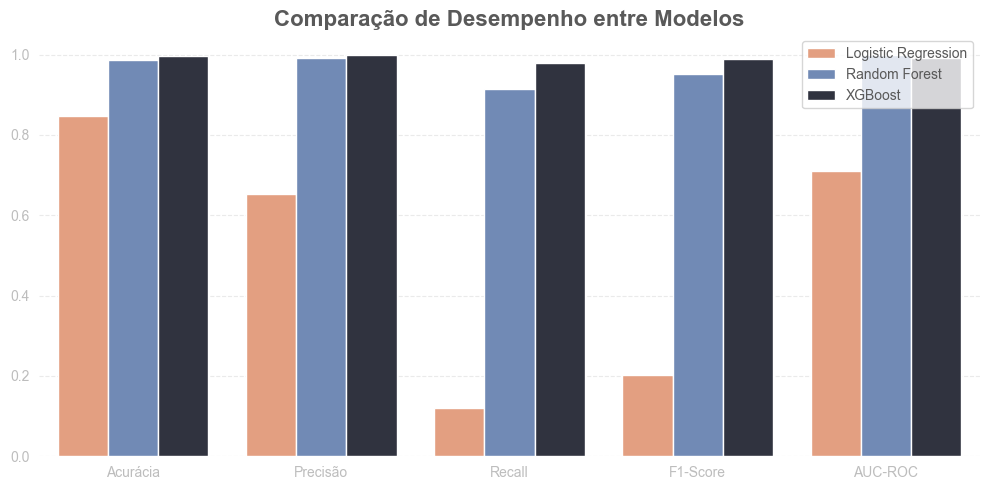

In [266]:
plot_model_comparison(metrics_df)

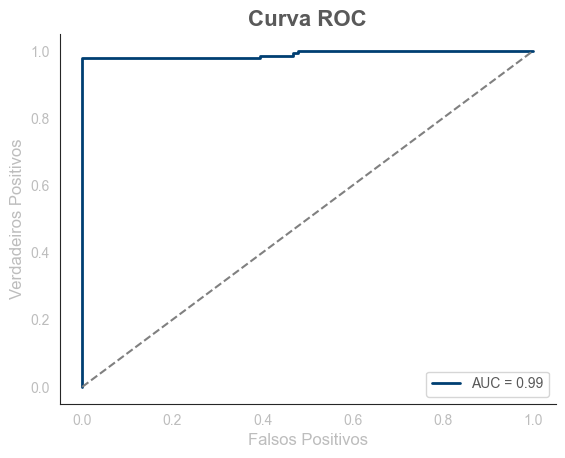

In [267]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
auc_value = roc_auc_score(y_test, y_proba_xgb)

plt.plot(fpr, tpr, color="#003F72", lw=2, label=f"AUC = {auc_value:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Falsos Positivos", fontsize=12)
plt.ylabel("Verdadeiros Positivos", fontsize=12)
plt.title("Curva ROC", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")
sns.despine()

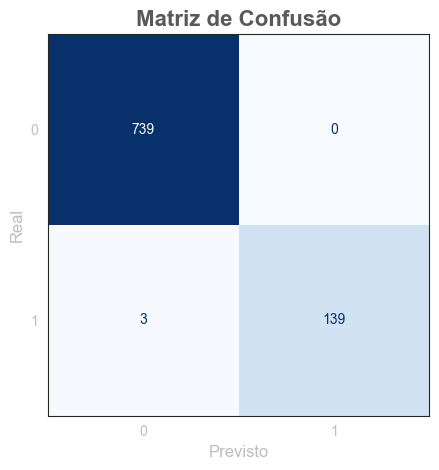

In [268]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=False, ax=plt.gca())
plt.title("Matriz de Confusão", fontsize=16, fontweight="bold")
plt.xlabel("Previsto", fontsize=12)
plt.ylabel("Real", fontsize=12)
plt.tight_layout()
plt.show()

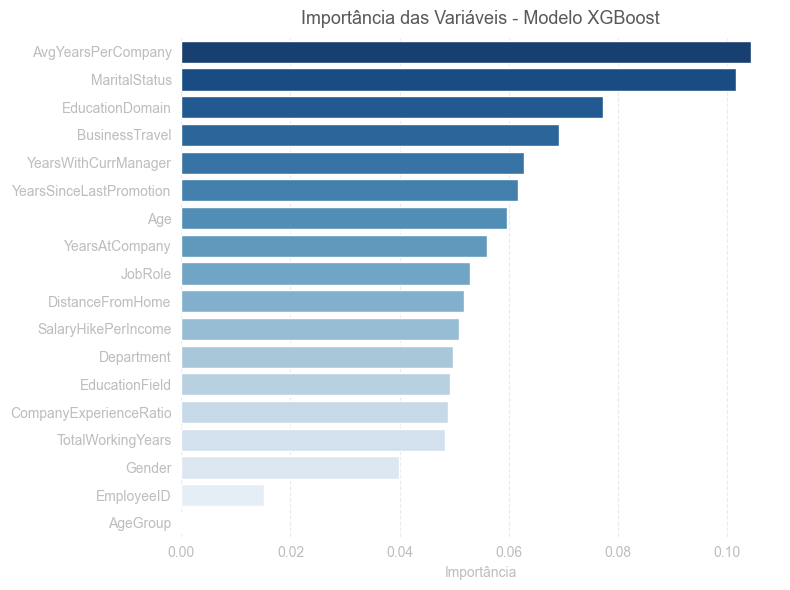

In [269]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost': xgb.feature_importances_
})

importances_sorted = importances.sort_values('XGBoost', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances_sorted,
    x='XGBoost',
    y='Feature',
    hue='Feature',
    palette='Blues_r',
    dodge=False,
    legend=False
)

plt.title('Importância das Variáveis - Modelo XGBoost', fontsize=13, pad=10)
plt.xlabel('Importância')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## 5. Modelo para dashboard

In [270]:
df_dash = df.copy()
df_dash = df_dash.drop(columns=['Education', 'FarFromHome', 'JobLevel', 'NumCompaniesWorked', 'PromotionRate', 'StockOptionLevel', 'TrainingTimesLastYear', 'MonthlyIncome', 'PercentSalaryHike', 'EmployeeID', 'YearsSinceLastPromotion', 'EducationField', 'AvgYearsPerCompany', 'SalaryHikePerIncome'])

In [275]:
df_dash.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Gender', 'JobRole', 'MaritalStatus', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsWithCurrManager', 'AgeGroup', 'EducationDomain',
       'CompanyExperienceRatio'],
      dtype='object')

In [271]:
num_cols_dash = df_dash.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_dash = df_dash.select_dtypes('category').columns.tolist()

encoders = {}

for col in categorical_cols_dash:
    le = LabelEncoder()
    df_dash[col] = le.fit_transform(df_dash[col])
    encoders[col] = le


In [272]:
X = df_dash.drop(columns=['Attrition'])
y = df_dash['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[num_cols_dash] = scaler.fit_transform(X_train[num_cols_dash])
X_test[num_cols_dash] = scaler.transform(X_test[num_cols_dash])

In [273]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Acurácia - XGBoost: {acc_xgb:.4f}")

Acurácia - XGBoost: 0.9943


In [274]:
joblib.dump(encoders, "../data/model/label_encoders.pkl")
print("✅ Encoders salvos com sucesso!")
joblib.dump(scaler, "../data/model/scaler.pkl")
joblib.dump(num_cols_dash, "../data/model/num_cols.pkl")
print("✅ Scaler e cols salvo com sucesso!")
joblib.dump(xgb, "../data/model/xgb_model.pkl")
print("✅ Modelo salvo como xgb_model.pkl")

✅ Encoders salvos com sucesso!
✅ Scaler e cols salvo com sucesso!
✅ Modelo salvo como xgb_model.pkl


In [278]:
metrics = {
    "Acurácia": accuracy_score(y_test, y_pred_xgb),
    "Precisão": precision_score(y_test, y_pred_xgb, zero_division=0),
    "Recall": recall_score(y_test, y_pred_xgb, zero_division=0),
    "F1-Score": f1_score(y_test, y_pred_xgb, zero_division=0),
    "AUC-ROC": roc_auc_score(y_test, y_proba_xgb)
}
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

joblib.dump(metrics, "../data/model/model_metrics.pkl")
joblib.dump(conf_matrix, "../data/model/confusion_matrix.pkl")

['../data/model/confusion_matrix.pkl']